---
# 0️⃣ Data Load

In [56]:
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype, is_numeric_dtype
from moda.dataprep import raw_to_ts, ts_to_range
import lasio
import math
import joypy
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import mode

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from dtaidistance import dtw
from dtaidistance import clustering

import time
from datetime import datetime, date, timedelta

import datetime as dt
import urllib
from urllib.error import URLError, HTTPError
import os
from dateutil import parser

import seaborn as sns
import matplotlib as mpl
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import koreanize_matplotlib
from highlight_text import fig_text, ax_text

import calmap
import calplot
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import dataframe_image as dfi
from PIL import Image

## 경고메세지 숨기기
import warnings
warnings.filterwarnings(action='ignore')
## 숨겼던 경고메세지 다시 보이게하기
# warnings.filterwarnings(action='default')

## 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline
# pd.options.display.float_format='{:.2f}'.format

## -------------------------------------------------------------------------------- ## ->|
YJPATH = r"F:/YJ-RnDnote-WS/data/"
YJPATH3 = r'F:/YJ-format-230125/data/'
NCPATH = r"C:/app/Git-WS/2022/local-yjtest/23-YJ-RnDnote/YJH-RnDnote-WS/data/"
INDIR = r"001_pbp_raw/" 
OUTDIR = r"002_pbp_interim/"
OUTDIR3 = r'interim/'

pf = pd.read_csv('F:/YJ-RnDnote-WS/data/003_kbo_record_raw/KBO-record-c-0122.csv', encoding='utf-8')
color = pd.read_csv("F:/YJ-format-230125/data/team_colors3.csv", encoding='cp949')

df = pd.read_csv(YJPATH + OUTDIR + r'pbp-zone-2023-02-20-2.csv', encoding='cp949', low_memory=False)
df["game_date"] = pd.to_datetime(df.game_date, format='%Y-%m-%d')

def two_digit(n): 
    return f"{n:02d}"
df['bs_cnt']=df['bs_cnt'].apply(two_digit)

def six_digit(n): 
    return f"{n:06d}"
df['bso_rcnt']=df['bso_rcnt'].apply(six_digit)

df.drop_duplicates(inplace=True)
df.shape

(1308468, 184)

---
# 1️⃣ Data Normalizing

### Step 1: Checking and preprocessing data.

### Step 2: Computing and visualizing RFM variables

In [106]:
DAY = timedelta(1)
rec_end = max(df['game_date'])+DAY
rfm_df = df.groupby('cid').agg({'game_date':lambda x:(rec_end-max(x)).days
                                                      ,'cid':'count'
                                                      ,'gid-intot-panum':'nunique'})

rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

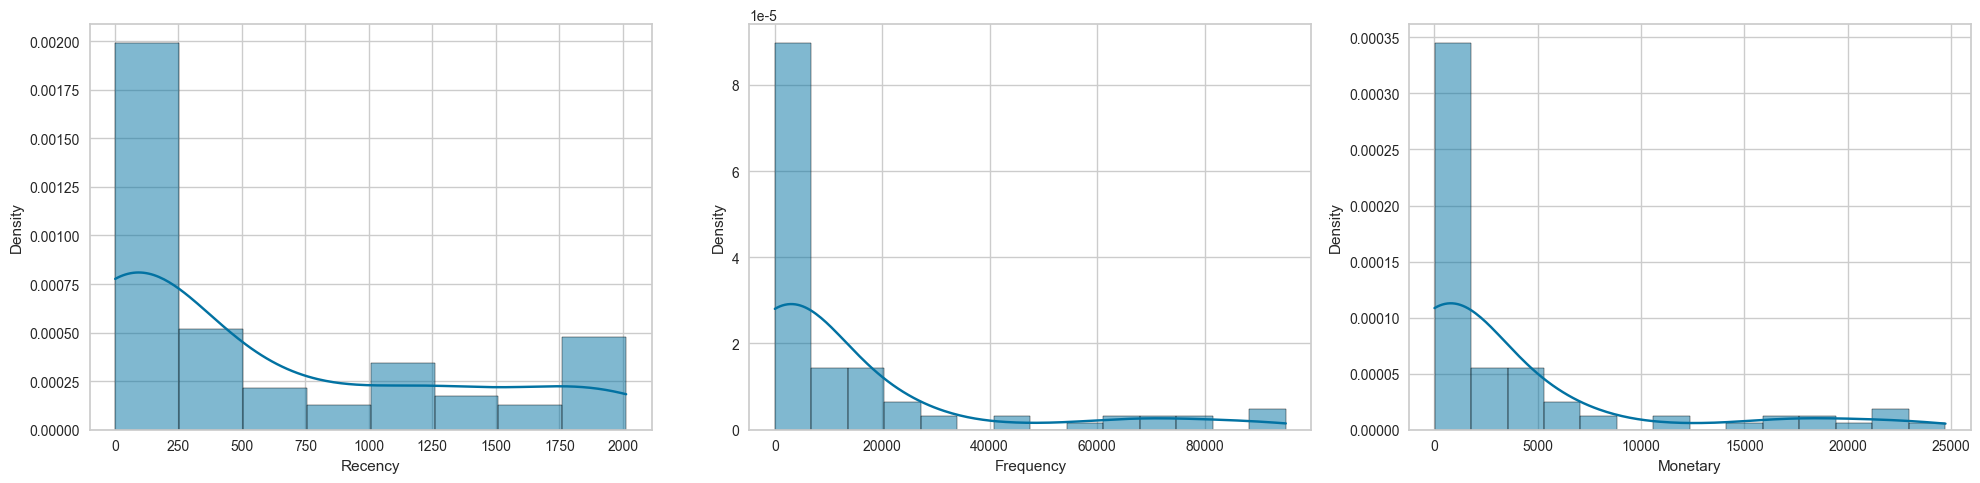

In [107]:
cols = ['Recency', 'Frequency', 'Monetary']

# create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(20,5))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(data=rfm_df[col], kde=True, stat='density', ax=ax)

fig.tight_layout()
plt.show()

In [108]:
display(rfm_df.describe())

,Recency,Frequency,Monetary
count,92.000000,92.000000,92.000000
mean,576.858696,14222.478261,3674.402174
std,685.184929,23970.770324,6199.592043
min,1.000000,7.000000,3.000000
25%,6.750000,311.750000,81.000000
50%,268.000000,2260.000000,559.500000
75%,1136.500000,16154.250000,4225.250000
max,2013.000000,95132.000000,24736.000000


<AxesSubplot: >

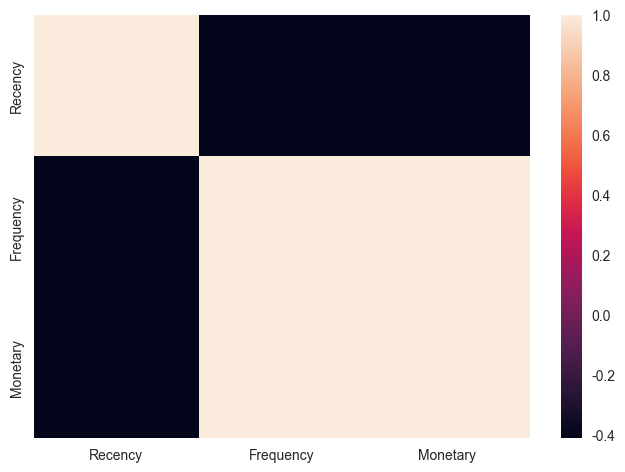

In [139]:
sns.heatmap(rfm_df.iloc[:, 0:3].corr())

### Step 3: Data Normalizing. The range of variables shows large variation. K-Means is distance based, so adjusting range common range is required to avoid building biased model.

In [110]:
scaler = MaxAbsScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary']
rfm_normalized.describe()

,n_Recency,n_Frequency,n_Monetary
count,92.000000,92.000000,92.000000
mean,0.286567,0.149503,0.148545
std,0.340380,0.251974,0.250630
min,0.000497,0.000074,0.000121
25%,0.003353,0.003277,0.003275
50%,0.133135,0.023756,0.022619
75%,0.564580,0.169809,0.170814
max,1.000000,1.000000,1.000000


### Step 4: Segmenting with K-Means. Identify the optimal k.

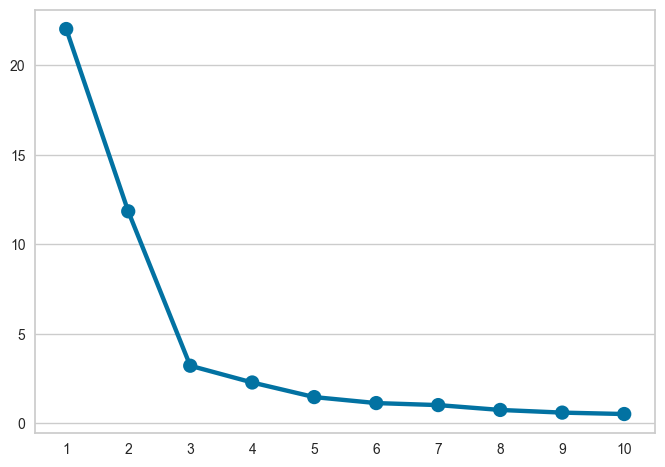

In [111]:
from sklearn.cluster import KMeans
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, random_state=0, n_init="auto").fit(rfm_normalized)
    SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=SSE)
plt.show()

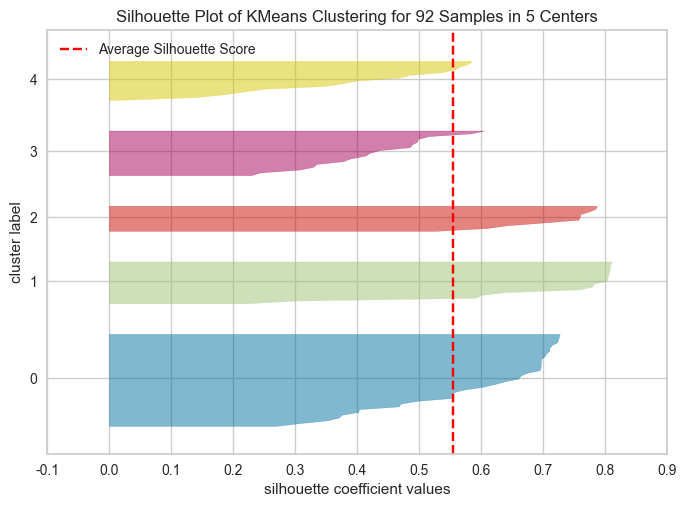

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 92 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [112]:
from yellowbrick.cluster import SilhouetteVisualizer
X = rfm_normalized

model = KMeans(5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

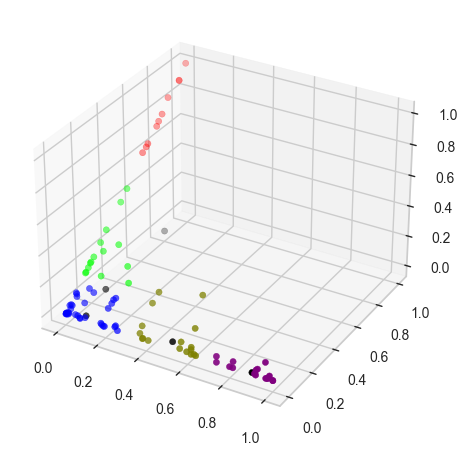

In [165]:
model = KMeans(5, random_state=0).fit(rfm_normalized)
centers=model.cluster_centers_
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(rfm_normalized['n_Recency'], rfm_normalized['n_Frequency'], rfm_normalized['n_Monetary']
           , cmap='brg', c=model.predict(rfm_normalized))
ax.scatter(centers[:,0], centers[:,1], c='black')

### Step 5: Identify the clusters for further analysis.

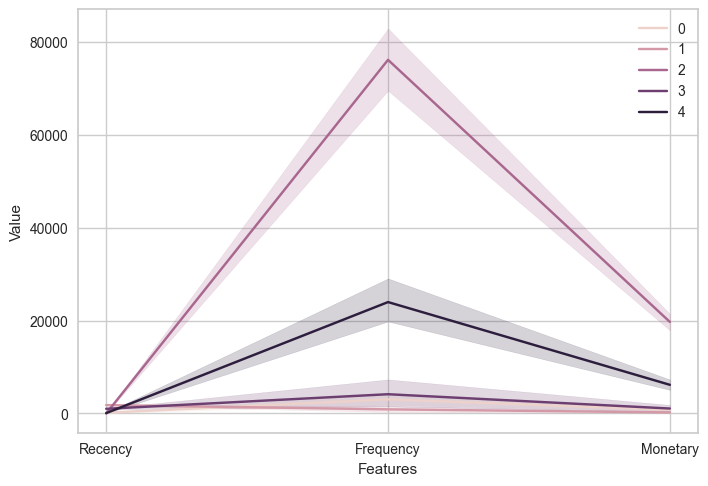

In [114]:
rfm_=pd.DataFrame(scaler.inverse_transform(rfm_normalized))

rfm_.columns = rfm_df.columns
rfm_['cid'] = rfm_df.index
rfm_['Cluster'] = model.labels_

melted_rfm_normalized = pd.melt(rfm_.reset_index()
                                , id_vars=['cid', 'Cluster']
                                , value_vars=['Recency', 'Frequency', 'Monetary']
                                , var_name='Features'
                                , value_name='Value')
sns.lineplot('Features', 'Value', hue='Cluster', data=melted_rfm_normalized)
plt.legend()

In [93]:
rfm_.groupby('Cluster').agg({
    'Recency':['mean', 'min', 'max']
    , 'Frequency':['mean', 'min', 'max']
    , 'Monetary':['mean', 'min', 'max', 'count']})

Recency                     Frequency                    \
                mean     min     max          mean      min      max   
Cluster                                                                
0         167.823529     4.0   522.0   3038.852941     11.0  10516.0   
1        1807.375000  1460.0  2013.0    890.312500      7.0   4832.0   
2           4.100000     1.0     7.0  76088.700000  59905.0  95132.0   
3        1010.470588   711.0  1285.0   4145.294118     20.0  19892.0   
4          81.866667     2.0   425.0  23969.666667  15244.0  47036.0   

             Monetary                          
                 mean      min      max count  
Cluster                                        
0          781.411765      3.0   2747.0    34  
1          232.562500      3.0   1267.0    16  
2        19703.800000  15786.0  24736.0    10  
3         1068.294118      5.0   5035.0    17  
4         6170.466667   3892.0  12110.0    15

# 2️⃣ RFM Scoring + K-Means

In [138]:
s1 = np.full((1, rfm_df.shape[0]-int(0.8*rfm_df.shape[0])), 1)
s2 = np.full((1, int(0.8*rfm_df.shape[0]) - int(0.6*rfm_df.shape[0])), 2)
s3 = np.full((1, int(0.6*rfm_df.shape[0]) - int(0.4*rfm_df.shape[0])), 3)
s4 = np.full((1, int(0.4*rfm_df.shape[0]) - int(0.2*rfm_df.shape[0])), 4)
s5 = np.full((1, int(0.2*rfm_df.shape[0]) - int(0.0*rfm_df.shape[0])), 5)
score = np.hstack((s1,s2,s3,s4,s5)).flatten()

rfm_df = rfm_df.sort_values(by='Recency', ascending=False)
rfm_df['r_score'] = score

for i,j in zip(('Frequency', 'Monetary'), ('f_score', 'm_score')):
    rfm_df = rfm_df.sort_values(by=i)
    rfm_df[j] = score
rfm_df

,Recency,Frequency,Monetary,r_score,f_score,m_score
cid,,,,,,
신성현-64086,2013,7,3,1,1,1
김재환-78224,381,11,3,3,1,1
이성열-73136,1638,11,3,1,1,1
이대호-71564,522,12,5,2,1,1
나주환-73209,1946,19,5,1,1,1
...,...,...,...,...,...,...
이재원-76812,7,75368,19576,4,5,5
장성우-78548,1,80690,21388,5,5,5
최재훈-78288,4,89465,22801,5,5,5


<AxesSubplot: >

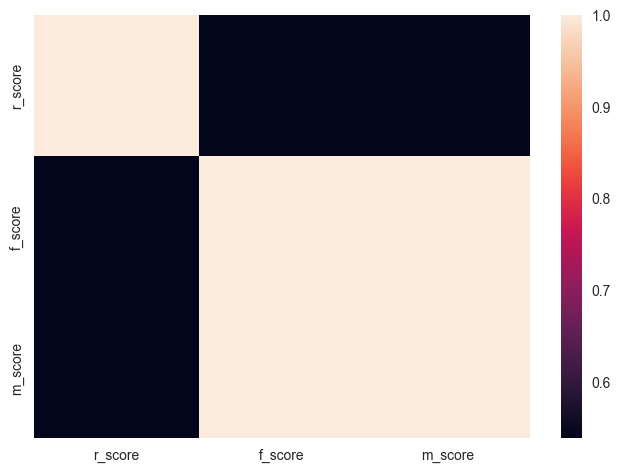

In [140]:
sns.heatmap(rfm_df.iloc[:, 3:6].corr())

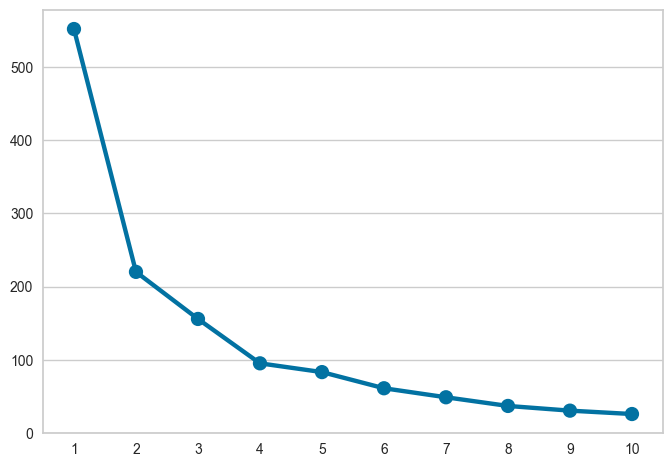

In [145]:
from sklearn.cluster import KMeans
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, random_state=0, n_init="auto").fit(rfm_df.iloc[:, 3:])
    SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=SSE)
plt.show()

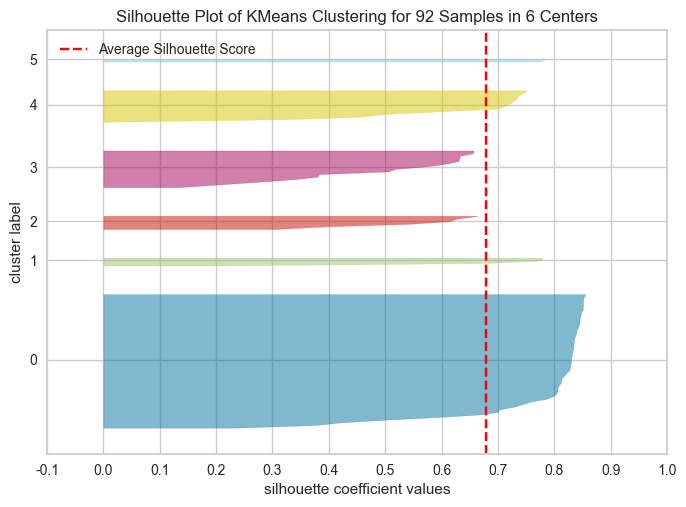

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 92 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [163]:
from yellowbrick.cluster import SilhouetteVisualizer
X = rfm_df

model = KMeans(6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

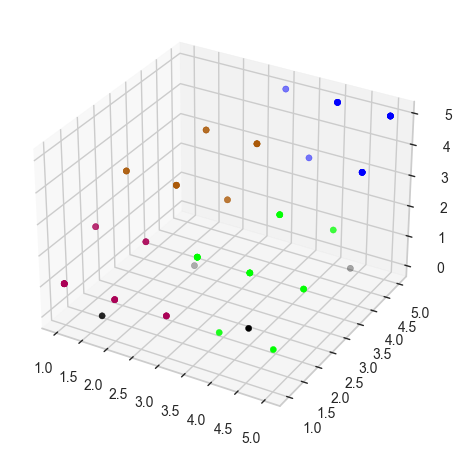

In [177]:
model = KMeans(4, random_state=0).fit(rfm_df[['r_score', 'f_score', 'm_score']])
centers=model.cluster_centers_
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(rfm_df['r_score'], rfm_df['f_score'], rfm_df['m_score']
           , cmap='brg', c=model.predict(rfm_df[['r_score', 'f_score', 'm_score']]))
ax.scatter(centers[:,0], centers[:,1], c='black')

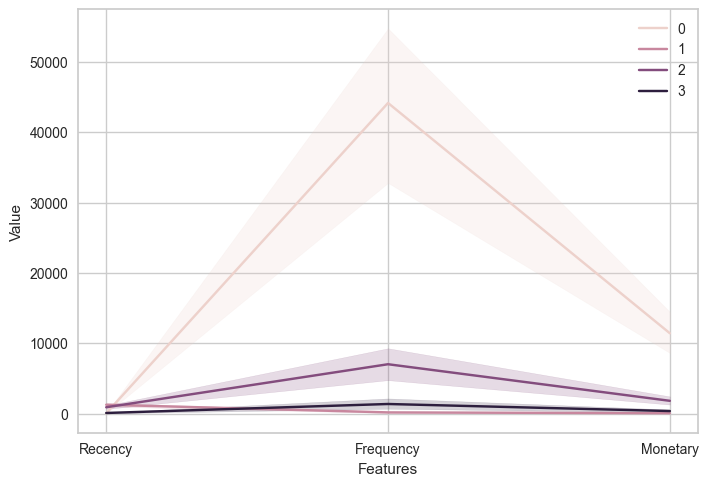

In [178]:
rfm_df['Cluster'] = model.labels_

melted_rfm = pd.melt(rfm_df.reset_index()
                                , id_vars=['cid', 'Cluster']
                                , value_vars=['Recency', 'Frequency', 'Monetary']
                                , var_name='Features'
                                , value_name='Value')
sns.lineplot('Features', 'Value', hue='Cluster', data=melted_rfm)
plt.legend()

In [185]:
rfm_df.groupby('Cluster').agg({
    'Recency':['mean', 'min', 'max', 'std', 'var']
    , 'Frequency':['mean', 'min', 'max', 'std', 'var']
    , 'Monetary':['mean', 'min', 'max', 'count', 'std', 'var']})

Recency                                           Frequency  \
                mean  min   max         std            var          mean   
Cluster                                                                    
0          28.440000    1   348   75.915018    5763.090000  44157.840000   
1        1247.956522  148  2013  609.637409  371657.770751    157.391304   
2         888.680000  105  1968  615.948098  379392.060000   7007.560000   
3          75.789474    4   361  111.442351   12419.397661   1353.315789   

                                                      Monetary               \
          min    max           std           var          mean   min    max   
Cluster                                                                       
0        7548  95132  28911.887566  8.358972e+08  11412.320000  1945  24736   
1           7    945    229.862951  5.283698e+04     41.521739     3    242   
2        1083  19892   5667.365482  3.211903e+07   1804.760000   286   5035   
3          62   6709   1725.968071  2.978966e+06    350.684211    14   1743   

                                          
        count          std           var  
Cluster                                   
0          25  7486.824270  5.605254e+07  
1          23    61.100416  3.733261e+03  
2          25  1455.600314  2.118772e+06  
3          19   451.415435  2.037759e+05

---

|클러스터|고객 유형|RFM 특성|액션|
|-|-|-|-|
|0|최고의 고객|자주 그리고 최근에 쇼핑하는 사람들. 지출이 많다.|신제품 출시 대상 고객이 될 가능성이 있습니다.|
|1|새 고객|빈도와 지출이 적은 최근 쇼핑객.|고객관계관리를 강조하여 쇼핑경험을 높이고 이에 따른 참여를 강화합니다.|
|2|떠날 위험에 처하여|쇼핑을 자주 하고 돈을 많이 쓴다. 마지막 거래 이후로 시간이 좀 지났습니다.|떠나는 이유를 알아보세요.맞춤형 마케팅 계획으로 다시 구매를 유도합니다.|
|3|잃어버린 고객|저주파 및 지출금액 광고는 최근에 주문을 하지 않고 있습니다.|사업 때문에 그들을 잃었을 수도 있다. 설문조사는 휘젓는 이유에 따라 실시되어야 한다. 제품 또는 서비스의 품질을 향상시켜 더 이상의 손실을 방지합니다

|Cluster|Customer Type|RFM Characteristics|Action|
|-|-|-|-|
|0|Best Customer|Frequent and recent shoppers. Heavy Spending.|Potential to be target customers for launch of new products.|
|1|New Customer|Recent shopper with low frequency and spending.|Emphasizing cuatomer relationship management to enhance shopping experience and hence strengthen the engagement.|
|2|At Risk of leaving/churned|Frequent and heavy spent shoppers. It has been some time since last transaction.|Figure out the reasons of leaving.Customized marketing plans encouraging purchase again.|
|3|Lost Customer|Low frequency and spending amount ad has not placing an order recently.|Business might have lost them. Survey to be done on reason of being churned. Enhance the quality of products or services to avoid further losing.|

---
# REF
- https://projectgurukul.org/customer-segmentation-project-machine-learning/
- https://medium.com/swlh/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-93aa4c79f7a7
- https://medium.com/mlearning-ai/demonstrating-customers-segmentation-with-dbscan-clustering-using-python-8a2ba0db2a2e